In [255]:
import sys
!conda install --yes --prefix {sys.prefix} lightgbm
!conda install --yes --prefix {sys.prefix} optuna
!conda install --yes --prefix {sys.prefix} shap

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



### Global imports for the project

In [256]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import optuna
import shap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report



# Initial code to read in data and do some basic validation

### Import all raw data into a dataframe and display the first 5 rows as a sanity check.

In [257]:
# Import data
file_path = "dataset_full.csv"
phishing_df = pd.read_csv ( file_path )
phishing_df.head (20 )

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
5,1,0,0,2,0,0,0,0,0,0,...,1,3,3,3591,1,0,0,0,0,1
6,2,0,0,0,0,0,0,0,0,0,...,1,2,2,291,0,0,0,0,0,0
7,2,0,0,3,0,0,0,0,0,0,...,1,2,1,3134,1,0,0,0,0,0
8,2,0,0,0,0,0,0,0,0,0,...,1,4,2,3596,1,1,0,0,0,0
9,1,0,0,2,0,0,0,0,0,0,...,1,2,1,14397,1,0,0,0,0,1


### Look at columns and types - sanity check

In [258]:
phishing_df.dtypes

qty_dot_url             int64
qty_hyphen_url          int64
qty_underline_url       int64
qty_slash_url           int64
qty_questionmark_url    int64
                        ...  
qty_redirects           int64
url_google_index        int64
domain_google_index     int64
url_shortened           int64
phishing                int64
Length: 112, dtype: object

In [259]:
phishing_df.columns

Index(['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url',
       'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
       'qty_exclamation_url', 'qty_space_url',
       ...
       'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname',
       'tls_ssl_certificate', 'qty_redirects', 'url_google_index',
       'domain_google_index', 'url_shortened', 'phishing'],
      dtype='object', length=112)

# Do a mini Exploratory Data Analysis (EDA)
### Print some basic data values
### We know the data, based on the 'phishing' column, classifies each row (which representes a URL) as either phishing of legitimate

In [260]:
legitimate_count = ( phishing_df['phishing'] == 0 ).sum ()
phishing_count = ( phishing_df['phishing'] == 1 ).sum ()

print ( f"Total legitimate websites: {legitimate_count}" )
print ( f"Total phishing websites: {phishing_count}" )

Total legitimate websites: 58000
Total phishing websites: 30647


In [261]:
zero_directory_length_count = ( phishing_df['directory_length'] == 0 ).sum ()

zero_file_length_count = ( phishing_df['file_length'] == 0 ).sum ()

zero_parameters_length_count = ( phishing_df['params_length'] == 0 ).sum ()

print ( f"Number of rows where directory length is 0: {zero_directory_length_count}" )
print ( f"Number of rows where file length is 0: {zero_file_length_count}" )
print ( f"Number of rows where parameters length is 0: {zero_parameters_length_count}" )

Number of rows where directory length is 0: 0
Number of rows where file length is 0: 19624
Number of rows where parameters length is 0: 0


In [262]:
#small_rows = phishing_df[(phishing_df['length_url'] >= 0) & (phishing_df['length_url'] <= 50) & (phishing_df['phishing'] == 1)]
#one_to_fifty_count = small_rows.shape[0]
#display ( small_rows )

one_to_fifty_count = phishing_df[(phishing_df['length_url'] >= 0) & (phishing_df['length_url'] <= 50) & (phishing_df['phishing'] == 1)].shape[0]

fiftyone_to_onehundred_count = phishing_df[(phishing_df['length_url'] >= 51) & (phishing_df['length_url'] <= 100) & (phishing_df['phishing'] == 1)].shape[0]

onehundredone_to_onehundredfifty_count = phishing_df[(phishing_df['length_url'] >= 101) & (phishing_df['length_url'] <= 150) & (phishing_df['phishing'] == 1)].shape[0]

greater_than_onehundredfifty_count = phishing_df[(phishing_df['length_url'] >= 151) & (phishing_df['phishing'] == 1)].shape[0]


print ( f"Number of phishing positive rows where length of URL is 1-50 characters: {one_to_fifty_count}" )
print ( f"Number of phishing positive rows where length of URL is 51-100 characters: {fiftyone_to_onehundred_count}" )
print ( f"Number of phishing positive rows where length of URL is 101-150 characters: {onehundredone_to_onehundredfifty_count}" )
print ( f"Number of phishing positive rows where length of URL is > 150 characters: {greater_than_onehundredfifty_count}" )

Number of phishing positive rows where length of URL is 1-50 characters: 16863
Number of phishing positive rows where length of URL is 51-100 characters: 9497
Number of phishing positive rows where length of URL is 101-150 characters: 1983
Number of phishing positive rows where length of URL is > 150 characters: 2304


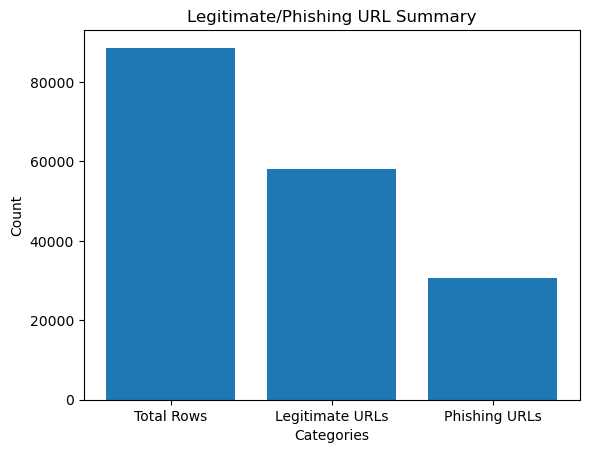

In [263]:
total_rows = phishing_df.shape[0]

counts = [total_rows, legitimate_count, phishing_count]
labels = ['Total Rows', 'Legitimate URLs', 'Phishing URLs']

plt.bar ( labels, counts )
plt.xlabel ( 'Categories' )
plt.ylabel ( 'Count' )
plt.title ( 'Legitimate/Phishing URL Summary' )
plt.show ()

# Look into correlation of features
### Get and print the raw correlation matrix

In [264]:
correlations = phishing_df.corr ().abs() #['phishing'].drop ( 'phishing' )
#correlations = phishing_df.corr().abs()['phishing'].drop('phishing')
print ( correlations )

                      qty_dot_url  qty_hyphen_url  qty_underline_url  \
qty_dot_url              1.000000        0.109737           0.127851   
qty_hyphen_url           0.109737        1.000000           0.213589   
qty_underline_url        0.127851        0.213589           1.000000   
qty_slash_url            0.246201        0.304762           0.246653   
qty_questionmark_url     0.409549        0.061247           0.067009   
...                           ...             ...                ...   
qty_redirects            0.051842        0.001930           0.013864   
url_google_index         0.004035        0.002939           0.001823   
domain_google_index      0.002490        0.006875           0.003421   
url_shortened            0.059222        0.010346           0.012158   
phishing                 0.171128        0.200382           0.191151   

                      qty_slash_url  qty_questionmark_url  qty_equal_url  \
qty_dot_url                0.246201              0.409549  

In [265]:
def create_top_pairs ( corr_matrix ):
    # Get the top n pairs with the highest correlation
    n = 10 # change this to the number of pairs you want to get

    top_pairs = corr_matrix.unstack ().sort_values ( ascending=False )#[:n * 2]
#    print ( top_pairs )

    unique_pairs = []

    pair_count = 0
    # Iterate over the top pairs and add only unique pairs to the list
    for pair in top_pairs.index:
        if pair[0] != pair[1] and ( pair[1], pair[0] ) not in unique_pairs:
#            print (f'Adding pair: {pair}')
            unique_pairs.append ( pair )
            pair_count += 1
            if pair_count >= n:
                break
            
    # Create a dataframe with the top pairs and their correlation coefficients
    top_pairs_df = pd.DataFrame ( columns=['feature_1', 'feature_2', 'corr_coef'] )
    for i, pair in enumerate ( unique_pairs[:n] ):
#        print ( f'{pair[0]}, {pair[1]}, {corr_matrix.loc[pair[0], pair[1]]}' )
        top_pairs_df.loc[i] = [pair[0], pair[1], corr_matrix.loc[pair[0], pair[1]]]

    return top_pairs_df

raw_top_pairs_df = create_top_pairs ( correlations )

# Print the top pairs as a dataframe
display ( raw_top_pairs_df )

,feature_1,feature_2,corr_coef
0,qty_hashtag_directory,qty_questionmark_file,1.0
1,qty_questionmark_directory,qty_dollar_file,1.0
2,qty_hashtag_directory,qty_questionmark_directory,1.0
3,qty_hashtag_directory,qty_slash_file,1.0
4,qty_hashtag_directory,qty_hashtag_file,1.0
5,qty_questionmark_directory,qty_questionmark_file,1.0
6,qty_hashtag_directory,qty_dollar_file,1.0
7,qty_slash_file,qty_questionmark_directory,1.0
8,qty_slash_file,qty_questionmark_file,1.0
9,qty_slash_file,qty_hashtag_file,1.0


In [266]:
droplist = []
keeplist = []
for col in correlations.columns:
    # print(correlation_matrix[col])
    gt80_index = correlations.loc[correlations[col]>=.80].index
    for ind in gt80_index:
        if ind!=col and ind not in keeplist:
            droplist.append(ind)
        else:
            keeplist.append(col)
            # df.drop(columns=[ind], inplace=True)
            # correlation_matrix = abs(df.corr())
droplist = list(set(droplist))
phishing_df.drop(columns=droplist, inplace=True)

phishing_df

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_exclamation_url,qty_space_url,qty_tilde_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,0,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,3,1,0,0,0,0,0,0,0,0,...,1,3,1,3597,0,0,0,0,0,0
88643,2,0,0,0,0,0,0,0,0,0,...,1,2,2,591,0,2,0,0,0,0
88644,2,1,0,5,0,0,0,0,0,0,...,1,2,5,14391,1,0,0,0,0,1
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,1,52,1,0,0,0,0,1


In [267]:
# Drop all columsn where every value in the column is 0
# Note that this should only be columns that start with 'qty_'
columns_all_zeros = phishing_df.loc[:, phishing_df.eq ( 0 ).all ()]
#print ( columns_all_zeros )
phishing_df.drop ( columns_all_zeros.columns, axis=1, inplace=True )

phishing_df.to_csv ( 'filtered_dataset.csv', index=False )

phishing_df


,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_exclamation_url,qty_space_url,qty_tilde_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,0,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,3,1,0,0,0,0,0,0,0,0,...,1,3,1,3597,0,0,0,0,0,0
88643,2,0,0,0,0,0,0,0,0,0,...,1,2,2,591,0,2,0,0,0,0
88644,2,1,0,5,0,0,0,0,0,0,...,1,2,5,14391,1,0,0,0,0,1
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,1,52,1,0,0,0,0,1


In [268]:
correlation_matrix = phishing_df.corr ()
mask = np.zeros_like(correlation_matrix, dtype=bool)

mask[np.triu_indices_from(mask)] = True

correlation_matrix[mask] = np.nan
(correlation_matrix
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_at_domain,qty_vowels_domain,domain_in_ip,server_client_domain,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_percent_directory,directory_length,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_percent_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
qty_dot_url,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_hyphen_url,0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_underline_url,0.13,0.21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_slash_url,0.25,0.30,0.25,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_questionmark_url,0.41,0.06,0.07,0.18,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_equal_url,0.50,0.18,0.33,0.29,0.46,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_at_url,0.17,0.04,0.06,0.10,0.13,0.17,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_exclamation_url,0.00,0.02,0.06,0.03,0.02,0.05,0.19,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_space_url,-0.00,0.02,-0.00,0.02,0.00,0.01,0.00,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_tilde_url,0.03,0.01,0.04,0.07,0.00,0.00,0.02,0.08,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [269]:
filtered_corr_matrix = phishing_df.corr ()

filtered_top_pairs_df = create_top_pairs ( filtered_corr_matrix )

# Print the top pairs as a dataframe
display ( filtered_top_pairs_df )

,feature_1,feature_2,corr_coef
0,qty_percent_url,qty_percent_directory,0.793843
1,qty_hyphen_directory,qty_hyphen_url,0.747148
2,qty_underline_url,qty_underline_params,0.741784
3,qty_questionmark_params,qty_dot_params,0.736039
4,qty_slash_url,directory_length,0.729849
5,qty_equal_url,qty_questionmark_params,0.719497
6,qty_equal_url,qty_dot_params,0.714725
7,qty_dot_url,qty_dot_params,0.709904
8,qty_slash_url,qty_dot_directory,0.704592
9,qty_slash_params,qty_questionmark_params,0.699622


# Machine Learning Models

In [270]:
# Define the features (X) and target (y)
X = phishing_df.drop(columns='phishing')  # Features are all columns except 'phishing'
y = phishing_df['phishing']    

In [271]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### First look using a RandomForestClassifier

In [272]:
# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [273]:
# Extract feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

In [274]:
print ( importances )

[1.10978059e-02 1.08018330e-02 4.32432443e-03 8.46341217e-02
 2.07899361e-05 4.11503886e-03 2.50702473e-04 9.89505685e-05
 3.47316088e-06 1.13536102e-04 1.19637782e-04 2.67349950e-04
 1.94424888e-05 1.97774935e-06 1.21588523e-05 9.43800594e-04
 2.16318116e-03 6.70718717e-02 1.89990376e-02 3.36110798e-03
 1.16987613e-05 2.14621071e-06 1.65645312e-02 3.92327224e-04
 1.05479978e-04 6.05818901e-02 7.79496319e-02 7.73770007e-02
 7.75624763e-02 1.32664108e-01 8.07645161e-02 5.94076021e-03
 2.68409373e-03 5.71587865e-03 1.99495565e-03 2.37138188e-03
 6.51565469e-03 4.05383460e-04 2.66327873e-02 5.11212352e-03
 2.57989122e-02 8.31527422e-02 2.34851409e-02 8.98791597e-03
 1.25861414e-02 1.27244170e-02 2.77509315e-02 6.14016061e-03
 8.14833055e-03 1.41502246e-04 7.06697222e-05 1.24416858e-03]


In [275]:
# Rank features by importance and display them
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                    Feature  Importance
29         directory_length    0.132664
3             qty_slash_url    0.084634
41   time_domain_activation    0.083153
30              file_length    0.080765
26     qty_hyphen_directory    0.077950
28    qty_percent_directory    0.077562
27  qty_underline_directory    0.077377
17               length_url    0.067072
25        qty_dot_directory    0.060582
46             ttl_hostname    0.027751
38            time_response    0.026633
40                   asn_ip    0.025799
42   time_domain_expiration    0.023485
18           qty_dot_domain    0.018999
22        qty_vowels_domain    0.016565
45           qty_mx_servers    0.012724
44          qty_nameservers    0.012586
0               qty_dot_url    0.011098
1            qty_hyphen_url    0.010802
43          qty_ip_resolved    0.008988
48            qty_redirects    0.008148
36       qty_percent_params    0.006516
47      tls_ssl_certificate    0.006140
31           qty_dot_params    0.005941


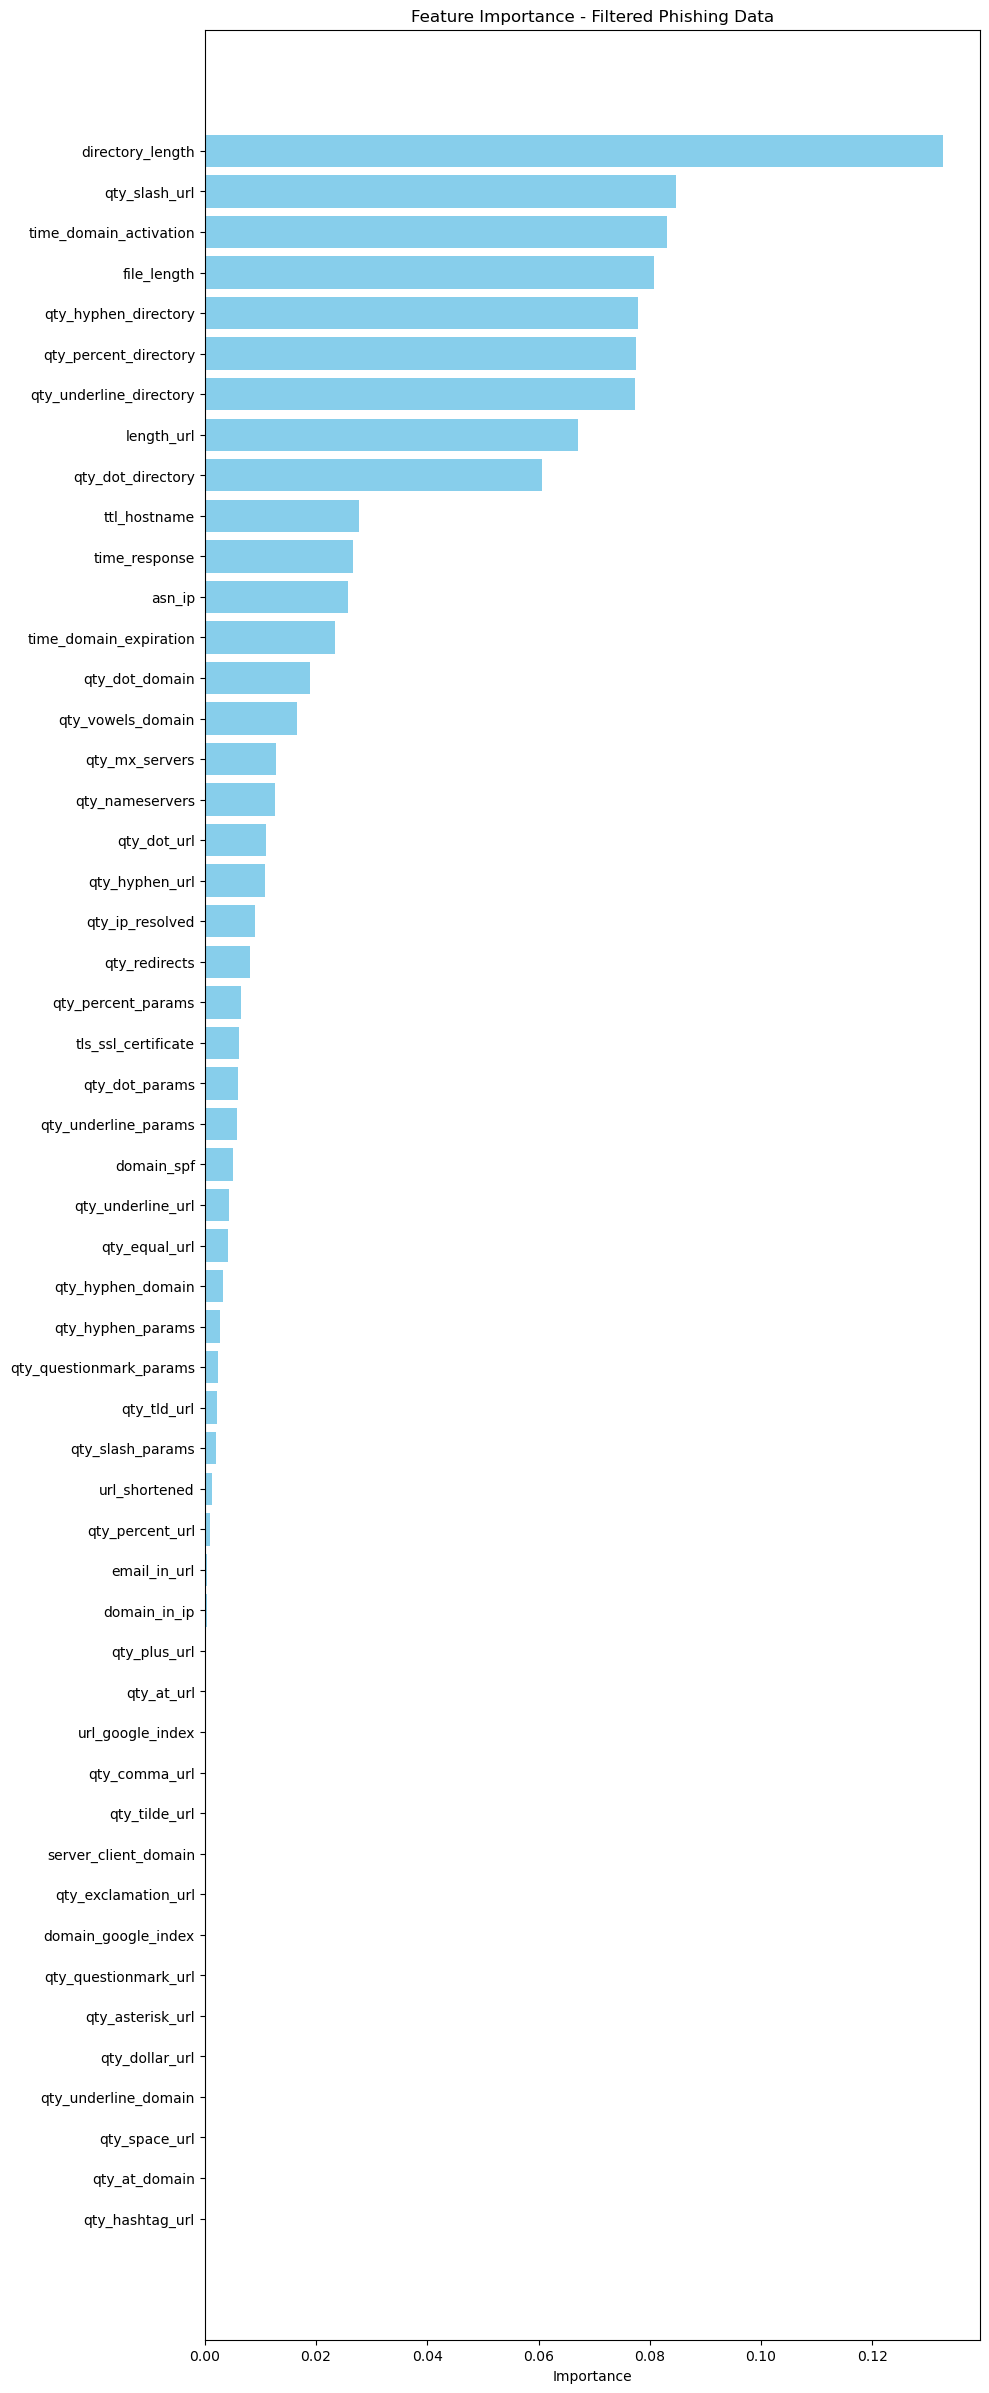

In [276]:
# Create a bar plot for feature importance
plt.figure(figsize=(10, 30))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance - Filtered Phishing Data')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

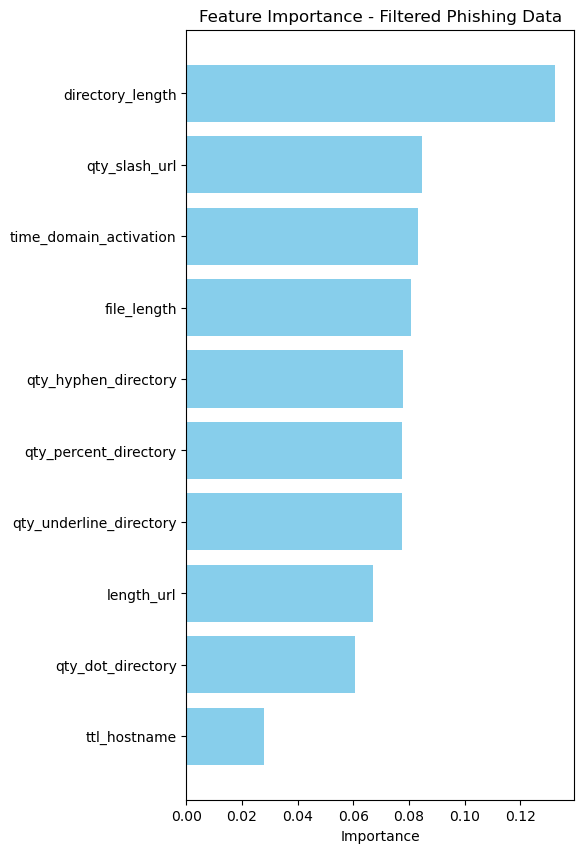

In [277]:
# Create a bar plot for feature importance
#print(type(feature_importance_df["Feature"]))

df_features = feature_importance_df.iloc[0:10, [0]].squeeze ()

#feature_importance_df["Feature"]
df_importances = feature_importance_df.iloc[0:10, [1]].squeeze ()
#print (df_importances)

plt.figure(figsize=(5, 10))
plt.barh(df_features, df_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance - Filtered Phishing Data')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

### Look at initial scores

In [278]:
# Evaluate the model before feature selection
accuracy_before = rf.score(X_test, y_test)
print(f'Accuracy of TEST data before feature selection: {accuracy_before:.2f}')

Accuracy of TEST data before feature selection: 0.97


In [279]:
# Evaluate the model before feature selection
accuracy_before = rf.score(X_train, y_train)
print(f'Accuracy of TRAIN data before feature selection: {accuracy_before:.2f}')

Accuracy of TRAIN data before feature selection: 1.00


In [280]:
# Select top N features (example selecting top 10 features)
top_features = feature_importance_df['Feature'][:10].values
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

In [281]:
# Train the Random Forest model with selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [282]:
# Evaluate the model after feature selection
accuracy_after = rf_selected.score(X_test_selected, y_test)
print(f'Accuracy of TEST after feature selection: {accuracy_after:.2f}')

Accuracy of TEST after feature selection: 0.96


In [283]:
# Evaluate the model after feature selection
accuracy_after = rf_selected.score(X_train_selected, y_train)
print(f'Accuracy of TEST after feature selection: {accuracy_after:.2f}')

Accuracy of TEST after feature selection: 1.00


In [284]:
# Create the Random Forest classifier model with a random_state for reproducibility
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Calculate training accuracy
train_accuracy = rf_model.score(X_train, y_train)

# Calculate testing accuracy
test_accuracy = rf_model.score(X_test, y_test)

# Validate the model by checking the model accuracy with model.score
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

Train Accuracy: 1.000
Test Accuracy: 0.969


## Training and Testing using the lightgbm model

In [285]:
# Define the features (X) and target (y)
X = phishing_df.drop ( columns='phishing' )  # Features are all columns except 'phishing'
y = phishing_df['phishing']  

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split ( X, y, test_size=0.3, random_state=42 )


In [286]:
# Create LightGBM datasets for training and testing
train_data = lgb.Dataset ( X_train, label=y_train )
test_data = lgb.Dataset ( X_test, label=y_test, reference=train_data )

In [287]:
# Define hyperparameters
params = {
    "objective": "binary",
    "boosting_type": "rf",
    "num_leaves": 5,
    "force_row_wise": True,
    "learning_rate": 0.5,
    "metric": "binary_logloss",
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8
}

# Train the LightGBM model
num_round = 500
bst = lgb.train ( params, train_data, num_round, valid_sets=[test_data] )

In [288]:
# Make predictions
y_pred = bst.predict ( X_test )

# Convert probabilities to binary predictions
y_pred_binary = ( y_pred > 0.5 ).astype ( int )

# Evaluate model
accuracy = accuracy_score ( y_test, y_pred_binary )
precision = precision_score ( y_test, y_pred_binary )
recall = recall_score ( y_test, y_pred_binary )
f1score = f1_score ( y_test, y_pred_binary )

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1score:.4f}")


Accuracy: 0.9187
Precision: 0.8409
Recall: 0.9416
F1-Score: 0.8884


In [289]:
# Generate classification report
report = classification_report(y_test, y_pred_binary)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     17449
           1       0.84      0.94      0.89      9146

    accuracy                           0.92     26595
   macro avg       0.90      0.92      0.91     26595
weighted avg       0.92      0.92      0.92     26595



In [290]:
# Load the data
# train_x_df = ...
# train_y = ...
# val_x_df = ...
# val_y = ...

classifier = None

def objective (
    trial: optuna.Trial,
    train_dataset: lgb.Dataset,
    val_dataset: lgb.Dataset,
    val_x_df: pd.DataFrame,
    val_y: np.ndarray,
) -> float:
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1, step=0.1),
        "verbose": -1
    }
    
    global classifier
    classifier = lgb.train (
        params,
        train_dataset,
        valid_sets=[val_dataset],
        callbacks=[
            lgb.early_stopping(
                20,
                verbose=False,
            ),
        ],
    )

    y_pred = classifier.predict(val_x_df)
    pred_labels = np.rint(y_pred)
    return accuracy_score(val_y, pred_labels)


# Create the train and validation datasets
train_dataset = lgb.Dataset(X_train, y_train, params={'verbose': -1}, free_raw_data=False)
val_dataset = lgb.Dataset(X_test, y_test, reference=train_dataset, params={'verbose': -1}, free_raw_data=False)

# Define the objective function
objective_func = lambda trial: objective(
    trial,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    val_x_df=X_test,
    val_y=y_test,
)

# Run the optimisation
study = optuna.create_study()
study.optimize(objective_func, n_trials=100)

# Get the best hyperparameters
print(study.best_params)

[I 2024-09-09 18:42:00,859] A new study created in memory with name: no-name-9ce0878a-729d-4c52-9c56-1ead97681bef
[I 2024-09-09 18:42:01,250] Trial 0 finished with value: 0.9485617597292724 and parameters: {'learning_rate': 0.11, 'min_data_in_leaf': 5400, 'max_depth': 5, 'feature_fraction': 1.0}. Best is trial 0 with value: 0.9485617597292724.
[I 2024-09-09 18:42:01,444] Trial 1 finished with value: 0.938334273359654 and parameters: {'learning_rate': 0.09999999999999999, 'min_data_in_leaf': 8000, 'max_depth': 3, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.938334273359654.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filte

{'learning_rate': 0.01, 'min_data_in_leaf': 9400, 'max_depth': 9, 'feature_fraction': 0.9}


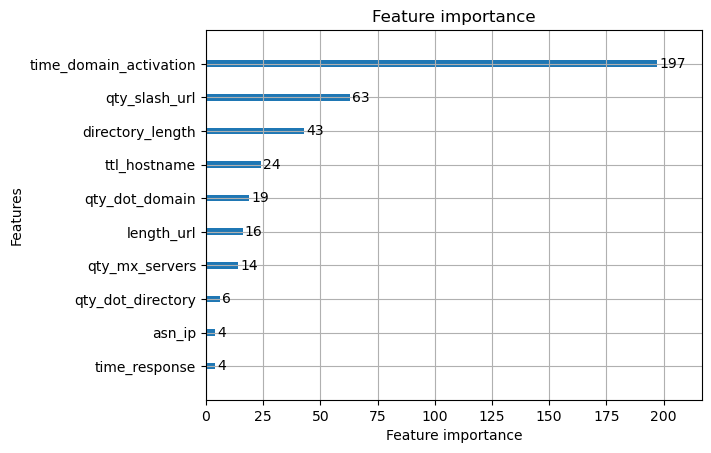

In [291]:
#
lgb.plot_importance ( classifier )
plt.show ()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


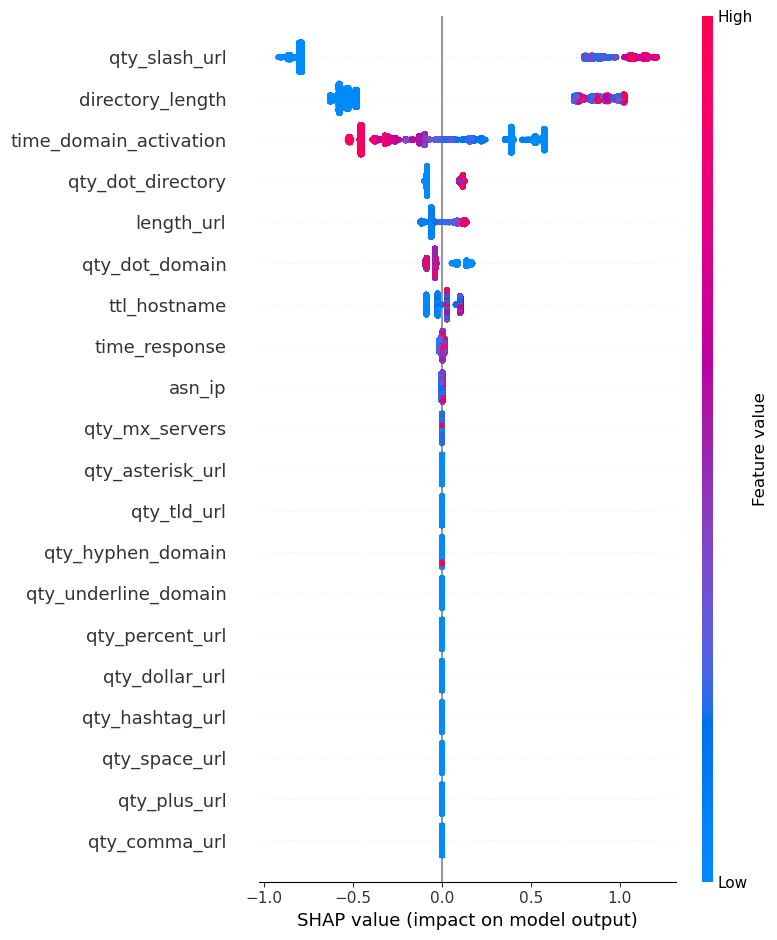

In [292]:
#
explainer = shap.TreeExplainer ( model=classifier )
shap_values = explainer.shap_values ( X_test )

shap.summary_plot ( shap_values[1], features=X_test )